In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


# Set your file path
data_path = r"C:\Users\saipr\anaconda3\Food_Contamination\Kitchen Eye"

categories = ["Contaminates", "Goodimg"]  # Folder names for each class

# Image parameters
img_height, img_width = 224, 224  # MobileNetV2 default size
batch_size = 32

# Function to load images and labels
def load_images_from_folder(data_path, categories):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                img = image.load_img(file_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load and split the dataset
images, labels = load_images_from_folder(data_path, categories)
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=123)

# Create TensorFlow datasets for efficient loading
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).shuffle(buffer_size=1000)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

# Load the MobileNetV2 model with pre-trained weights and exclude the top layers
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the base model
from tensorflow.keras.regularizers import l2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (contaminated or good)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=2,           # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the frozen base model
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs,callbacks=[early_stopping])



ModuleNotFoundError: No module named 'tensorflow.keras'

In [49]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9755 - loss: 0.3265
Test accuracy: 96.49%


In [52]:
# Save the trained model in HDF5 format
model.save('model.h5')  # Replace 'my_model.h5' with your desired filename and path


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
Prediction: Contaminated Food


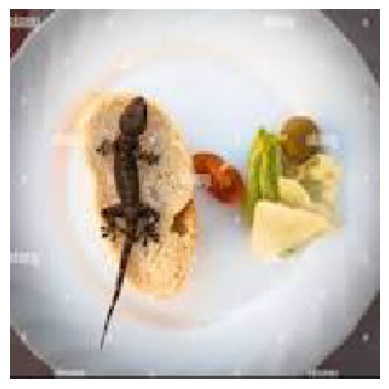

In [3]:
#Input Direct Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model (use the model path if it's saved as a .h5 file or .keras)
# If the model is saved in your directory (replace the path below with the actual model path)
model = tf.keras.models.load_model('model.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Example image path (replace with the path to your image)
img_path = "C:\\Users\\munuk\\Downloads\\test5.jpeg"

# Preprocess the image
img_array = preprocess_image(img_path)

# Make the prediction
prediction = model.predict(img_array)

# Interpret the prediction (Assuming binary classification: contaminated or good food)
if prediction[0] > 0.5:
    print("Prediction: Good Food")
else:
    print("Prediction: Contaminated Food")

# Display the image
import matplotlib.pyplot as plt
plt.imshow(img_array[0])  # img_array[0] since img_array has an extra dimension
plt.axis('off')  # Hide axis
plt.show()

In [69]:
model.save('my_model.h5')

In [7]:
import os

# Path to the folder containing images
folder_path = "C:\\Users\\saipr\\anaconda3\\Kitchen1\\Kitchen Eye\\contaminates"

# Define common image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')

# Count images
image_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(image_extensions))

print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 220


In [1]:
#input through vedio
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('model.h5')  # Load the saved model

# Function to process and predict from a webcam frame
def predict_from_webcam(frame):
    # Resize the frame to match input size expected by the model
    img_resized = cv2.resize(frame, (224, 224))  # Resize to 224x224 as expected by MobileNetV2
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess image for MobileNetV2

    # Predict using the model
    prediction = model.predict(img_array)
    
    # Get the predicted class (0 or 1)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Goodimg'
    return predicted_class

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam, change to 1, 2, etc. if you have multiple cameras

while True:
    ret, frame = cap.read()  # Capture frame-by-frame

    if not ret:
        break  # If frame capture failed, exit

    # Flip the frame horizontally for better user experience
    frame = cv2.flip(frame, 1)

    # Predict the class from the webcam input
    prediction = predict_from_webcam(frame)

    # Display the prediction on the webcam feed
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f'Prediction: {prediction}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Webcam', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [12]:
import pyttsx3

# Initialize the text-to-speech engine
tts_engine = pyttsx3.init()

# Function to play a voice alert
def voice_alert(message):
    tts_engine.say(message)
    tts_engine.runAndWait()


In [14]:
def predict_from_webcam(frame):
    img_resized = cv2.resize(frame, (224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Goodimg'
    
    # Trigger voice alert if contaminated food is detected
    if predicted_class == 'Contaminates':
        voice_alert("Warning! Contaminated food detected!")
    
    return predicted_class


In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pyttsx3

# Initialize the text-to-speech engine
tts_engine = pyttsx3.init()

# Function to play a voice alert
def voice_alert(message):
    tts_engine.say(message)
    tts_engine.runAndWait()

# Load the trained model
model = tf.keras.models.load_model('model.h5')  # Ensure your model is saved as 'model.h5'

# Function to preprocess an image frame
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize as per MobileNetV2
    return img_array

# Function to predict and trigger TTS alert if contaminated food is detected
def predict_from_webcam(frame):
    # Resize frame to match model input size
    img_resized = cv2.resize(frame, (224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the prediction from the model
    prediction = model.predict(img_array)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Goodimg'
    
    # Trigger voice alert for contaminated food
    if predicted_class == 'Contaminates':
        voice_alert("Warning! Contaminated food detected!")
    
    return predicted_class

# Initialize the webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam, adjust if you have multiple cameras

print("Press 'q' to exit the webcam feed.")
while True:
    ret, frame = cap.read()  # Capture a frame

    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    # Flip the frame horizontally for a mirror view
    frame = cv2.flip(frame, 1)

    # Predict the class and get the result
    prediction = predict_from_webcam(frame)

    # Display the prediction on the webcam feed
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f'Prediction: {prediction}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the webcam feed
    cv2.imshow('Webcam', frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to exit the webcam feed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━

In [17]:
from twilio.rest import Client

# Twilio credentials
account_sid = "AC431f8830e8afed4a2d71f0b4e3c29d48"
auth_token = "fd08589312b3ce2a34aaec9ab2d031b0"
twilio_phone_number = "+15414226980"  # Replace with your Twilio phone number
recipient_phone_number = "+919392551869"  # Replace with the recipient's phone number

# Function to send SMS alert
def send_sms_alert(message):
    client = Client(account_sid, auth_token)
    client.messages.create(
        body=message,  # Message content
        from_=twilio_phone_number,  # Your Twilio number
        to=recipient_phone_number  # Recipient's number
    )


In [21]:
# Twilio Sandbox for WhatsApp credentials
whatsapp_sender = "whatsapp:+14155238886"  # Twilio Sandbox number for WhatsApp
recipient_whatsapp_number = "whatsapp:+919392551869"  # Recipient's WhatsApp number

# Function to send WhatsApp alert
def send_whatsapp_alert(message):
    client = Client(account_sid, auth_token)
    client.messages.create(
        body=message,  # Message content
        from_=whatsapp_sender,  # Twilio Sandbox for WhatsApp
        to=recipient_whatsapp_number  # Recipient's WhatsApp number
    )


In [22]:
def predict_from_webcam(frame):
    img_resized = cv2.resize(frame, (224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Goodimg'
    
    if predicted_class == 'Contaminates':
        # Voice alert
        voice_alert("Warning! Contaminated food detected!")
        
        # Send SMS alert
        send_sms_alert("Alert: Contaminated food detected!")
        
        # Send WhatsApp alert
        send_whatsapp_alert("⚠️ Alert: Contaminated food detected!")
    
    return predicted_class
